# 8. Multi-Pass Feature Selection and Optimization



## Math

**To simulate data:**

We can define our simulation output $y_i$ as follows:

$$ y_i = f(x_i) + \varepsilon(x_i) + \eta_i $$

Where:  
- $f(x_i) = x_i^\top \beta $ represents the linear mean function  
- $\varepsilon(x_i) \sim \mathcal{GP}(0, k(x_i, x_i')) $ represents structured noise from a Gaussian Process  
- $ \eta_i \sim \mathcal{N}(0, \sigma^2) $ represents small independent Gaussian noise

**Methods Used**

0. Standard Gaussian Process
    - RBF Kernel using a shared lengthscale for all features
1. GPFLow's Automatic Relevance Detection (ARD): 
    - Uses an RBF kernel with a separate lengthscale for each feature
    - Features with large lengthscales can be considered irrelevant
2. ARD with Custom Feature Selection Function
    - Applies Lasso-based feature selection
    - Uses an ARD RBF kernel (separate lengthscales per selected feature)
3. No ARD, Custom Feature Selection Function
    - Applies Lasso-based feature selection
    - Uses an RBF kernel with a shared lengthscale across selected features
4. Direct Optimization
    - Adds an L1 penalty term directly to the training loss during optimization
    - Features with coefficients close to zero can be considered irrelevant

**Spoiler**

- While direct optimization performs better than plain ARD on very sparse data, the custom method of feature selection consistently outperform the other methods–whether using separate or shared lengthscales with the RBF kernel.

## Code

### Setup

In [714]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gpflow as gpf
import tensorflow as tf

from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### Simulating Sparse Data

In [715]:
def sim_sparse(n = 100, m = 20, seed = 22, same_lengthscales = False):

    X = np.random.randn(n,m)

    # linear mean
    beta = np.zeros(m)
    beta[3] = 7.3
    beta[5] = 0.5
    beta[7] = -2.0
    beta[11] = 1.1
    beta[12] = -0.8
    beta[20] = 1
    lin_mean = X @ beta

    if same_lengthscales:
        lengthscales = 2.1
        sigma = 0.6
        
        z = X[:, 3].reshape(-1, 1) # create column vector n x 1 based on third feature
        z_pairwise_diff = z - z.T # (n x n) matrix of pairwise differences
        z_squared_dist = z_pairwise_diff ** 2 

        K = sigma **2 * np.exp(-z_squared_dist / (2 * lengthscales **2))

        # ard rbf kernel
    else: 
        gp_features = [3, 12, 20] # separate from linear features
        lengthscales = np.array([0.2, 0.8, 3.0])
        sigma = 0.6

        X_gp = X[:, gp_features] / lengthscales
        sq_norms = np.sum(X_gp**2, axis=1).reshape(-1, 1)
        dists = sq_norms + sq_norms.T - 2 * (X_gp @ X_gp.T)
        K = sigma**2 * np.exp(-0.5 * dists)

    # gaussian process noise
    gp_noise = np.random.multivariate_normal(mean = np.zeros(n), cov = K)

    # iid normal noise
    eta = np.random.normal(0, 0.05, size = n)

    # combined
    y = lin_mean + gp_noise + eta

    return X, y, beta, lengthscales


### Main Function

In [716]:
def l1_feat_select (model, X, y, init_kernel, shared_lengthscale = 0, penalty_strength = 0.1, max_iter = 10, verbose = 1):
    """ 
    Multi-pass optimization using Lasso-based feature selection and Gaussian Process optimization.

    Runs an iterative loop that uses LassoCV to select relevant input features, then updates the kernel of GP model to use only those features. 
    The loop stops when feature selection and mean function coefficients converge, or when the maximum number of iterations is reached

    Parameters:
    ----------
        model: gpflow.models.GPR
            The GP model to optimize. 
        X: tf.Tensor or np.ndarray
            Input features
        y: tf.Tensor or np.ndarray
            Target values
        init_kernel: gpflow.kernels.Kernel
            The initial GP kernel
        shared_lengthscale: bool, optional
            If true, all features will share one lengthscale. Default is 0. 
        penalty_strength: float, optional
            Strength of L1 penalty term. Default is 0.1. Must be positive.
        max_iter: int, optional
            Maximum number of alternating iterations. Default is 10
        verbose: bool, optional
            Will show output. Default is 1

    Returns:
    -------
        model: gpflow.models.GPR
            The optimized GP model
        selected_feats: 
            Indices of selected features
    
    """

    X_current = X
    m = X_current.shape[1]
    current_kernel = init_kernel
    active_dims = list(range(X.shape[1]))
    count = 0
    tol = 1e-6

    selected_feats = None

    while True:

        count += 1

        alt_las = LassoLars(alpha = penalty_strength, random_state = 22)
        alt_las.fit(X_current, y.reshape(-1))

        # Store old values
        prev_A = model.mean_function.A 
        prev_b = model.mean_function.b
        
        if verbose:
            print(f"\n --- Beginning Iteration {count} --- ")
            print(f'Lasso Coefficients: {alt_las.coef_}')


        # Select features
        select_mask = np.abs(alt_las.coef_) > 0
        if not np.any(select_mask):
            if verbose:
                print(f"No features selected. Skipping.")
            return model, selected_feats


        prev_active_dims = active_dims # save old value
        active_dims = np.where(select_mask)[0].tolist() # set new value for active dimensions

        if selected_feats == None:
            selected_feats = active_dims.copy()
        if verbose:
            print(f'Selected Features: {select_mask}')
            print('active dims', active_dims)

        # Update
        m = X_current.shape[1]
        new_A = alt_las.coef_[select_mask].reshape(-1,1)

        X_current = X_current[:, active_dims]
        model.data = (X_current, y)
        new_active_dims = list(range(X_current.shape[1])) # because indices change

        if shared_lengthscale:
            model.kernel = gpf.kernels.SquaredExponential(
                lengthscales = 1,
                active_dims=new_active_dims
            )
        else:
            model.kernel = gpf.kernels.SquaredExponential(
                lengthscales = np.ones(len(new_active_dims)),
                active_dims=new_active_dims
            )

        model.mean_function = gpf.functions.Linear(A=new_A, b = prev_b) # where is beta 0?

        # Use Lasso coefficients, don't optimize
        gpf.set_trainable(model.mean_function.A, False)
        gpf.set_trainable(model.mean_function.b, False)

        # Optimize kernel parameters
        opt = gpf.optimizers.Scipy()
        opt.minimize(model.training_loss, model.trainable_variables)

        if count >= max_iter:
            print('Too Many Iterations')
            break

        # stop when active dimensions and linear weights stabilize, 
        if active_dims == prev_active_dims and tf.reduce_max(tf.abs(new_A - prev_A)) < tol:
            if verbose:
                print(f"\n ! Converged ! ")
            break

    return model, selected_feats

### Data

In [717]:
X, y, beta_star, lengthscales = sim_sparse(n = 200, m = 100, seed = 22, same_lengthscales = False)

Xtrain_unscaled, Xtest_unscaled, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 22)

scaler = StandardScaler()
Xtrain = scaler.fit_transform(Xtrain_unscaled)
Xtest = scaler.transform(Xtest_unscaled)
ytrain = ytrain.reshape(-1,1)
ytest = ytest.reshape(-1,1)
m = Xtrain.shape[1]

### 0. GP - shared lengthscale

In [718]:
A_init = tf.zeros((m, 1), dtype=tf.float64)
b_init = tf.zeros((1,), dtype=tf.float64)

kernel = gpf.kernels.SquaredExponential(lengthscales=1)
likelihood = gpf.likelihoods.Gaussian()
mean_function = gpf.functions.Linear(A=A_init, b = b_init) 

opt = gpf.optimizers.Scipy()

In [719]:
mod0 = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=kernel, 
    likelihood = likelihood,
    mean_function = mean_function
    )

opt = gpf.optimizers.Scipy()
opt.minimize(mod0.training_loss, mod0.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 38.97548928423001
        x: [ 5.413e-01 -3.020e+00 ...  5.429e-02 -6.670e-01]
      nit: 71
      jac: [ 0.000e+00  3.998e-04 ...  1.243e-04 -3.746e-05]
     nfev: 86
     njev: 86
 hess_inv: <104x104 LbfgsInvHessProduct with dtype=float64>

In [720]:
y_pred0, y_var0 = mod0.predict_y(Xtest)
rmse0 = mean_squared_error(ytest, y_pred0, squared=False)
print(f'RMSE Model 1: {rmse0:.3f}')

RMSE Model 1: 0.858


In [721]:
mod0

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(100, 1)",float64,[[-3.83879325e-02...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[-0.6670382]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.0476520147573713
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.04765296510543715


### 1. GPFlow's Automatic Relevance Detection - allowing separate lengthscales

In [722]:
A_init = tf.zeros((m, 1), dtype=tf.float64)
b_init = tf.zeros((1,), dtype=tf.float64)

kernel = gpf.kernels.SquaredExponential(lengthscales=np.ones(m))
likelihood = gpf.likelihoods.Gaussian()
mean_function = gpf.functions.Linear(A=A_init, b = b_init) 

opt = gpf.optimizers.Scipy()

In [723]:
mod1 = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=kernel, 
    likelihood = likelihood,
    mean_function = mean_function
    )

opt = gpf.optimizers.Scipy()
opt.minimize(mod1.training_loss, mod1.trainable_variables)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 38.97548928423018
        x: [ 5.413e-01  5.413e-01 ...  5.429e-02 -6.670e-01]
      nit: 71
      jac: [ 0.000e+00  0.000e+00 ...  1.243e-04 -3.746e-05]
     nfev: 86
     njev: 86
 hess_inv: <203x203 LbfgsInvHessProduct with dtype=float64>

In [724]:
mod1.kernel.lengthscales

<Parameter: name=softplus, dtype=float64, shape=[100], fn="softplus", numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])>

In [725]:
y_pred1, y_var1 = mod1.predict_y(Xtest)
rmse1 = mean_squared_error(ytest, y_pred1, squared=False)
print(f'RMSE Model 1: {rmse1:.3f}')

RMSE Model 1: 0.858


### 2. ARD + Selecting Active Dimensions - separate lengthscales, selecting features

In [726]:
A_init = tf.zeros((m, 1), dtype=tf.float64)
b_init = tf.zeros((1,), dtype=tf.float64)

kernel = gpf.kernels.SquaredExponential(lengthscales=np.ones(m))
likelihood = gpf.likelihoods.Gaussian()
mean_function = gpf.functions.Linear(A=A_init, b = b_init) 

opt = gpf.optimizers.Scipy()

In [727]:
mod2 = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=kernel, 
    likelihood = likelihood,
    mean_function = mean_function
    )

mod2, selected_feats2 = l1_feat_select(
    model = mod2, 
    X = Xtrain, 
    y = ytrain, 
    init_kernel = gpf.kernels.SquaredExponential(
        lengthscales=np.ones(m)), 
    penalty_strength = 0.2)


 --- Beginning Iteration 1 --- 
Lasso Coefficients: [ 0.          0.          0.          6.61485423  0.          0.1975199
  0.         -1.51363904  0.          0.          0.          0.9297189
 -0.65320401  0.          0.          0.          0.          0.
  0.          0.          0.8221961   0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.       

In [728]:
y_pred2, y_var2 = mod2.predict_y(Xtest[:,selected_feats2])
rmse2 = mean_squared_error(ytest, y_pred2, squared=False)
print(f'RMSE Model 2: {rmse2:.3f}')

RMSE Model 2: 0.533


#### 2b. Testing Against Different Lambda Values

In [729]:
rmse_vals_2b = []
lbda_vals_2b = []


for lbda in np.logspace(-2, 2, 40):
    A_init = tf.zeros((m, 1), dtype=tf.float64)
    b_init = tf.zeros((1,), dtype=tf.float64)

    kernel = gpf.kernels.SquaredExponential(lengthscales = np.ones(m))
    likelihood = gpf.likelihoods.Gaussian()
    mean_function = gpf.functions.Linear(A=A_init, b = b_init) 

    opt = gpf.optimizers.Scipy()

    mod2b = gpf.models.GPR(
        data=(Xtrain, ytrain), 
        kernel=kernel, 
        likelihood = likelihood,
        mean_function = mean_function
        )
    
    mod2b, selected_feats2b = l1_feat_select(
        model = mod2b, 
        X = Xtrain, 
        y = ytrain, 
        init_kernel = gpf.kernels.SquaredExponential(
            lengthscales=np.ones(m)), 
        penalty_strength = lbda,
        verbose=0)
    
    y_pred, y_var = mod2b.predict_y(Xtest[:, selected_feats2b])
    y_pred = np.squeeze(y_pred) # remove weirdness with dimensions when nothing is chosen
    y_var = np.squeeze(y_var)
    rmse = mean_squared_error(ytest, y_pred, squared=False)

    rmse_vals_2b.append(rmse)
    lbda_vals_2b.append(lbda)

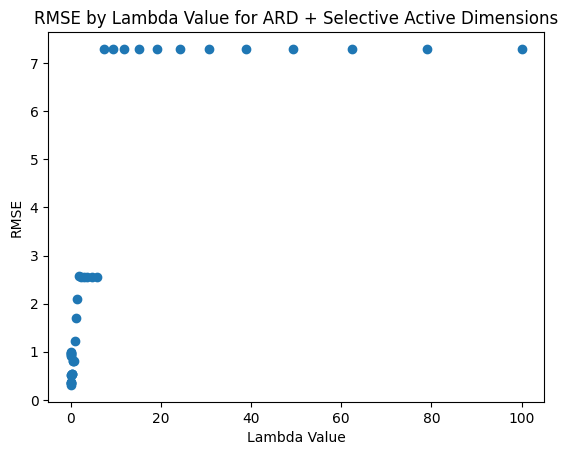

In [730]:
plt.scatter(lbda_vals_2b, rmse_vals_2b)
plt.title('RMSE by Lambda Value for ARD + Selective Active Dimensions')
plt.ylabel('RMSE')
plt.xlabel('Lambda Value')
plt.show()

In [731]:
rmse2b = np.min(rmse_vals_2b)
lbda2b = lbda_vals_2b[np.argmin(rmse_vals_2b)]

print(f'Lowest RMSE: {rmse2b:.3f}')
print(f'Best Lambda: {lbda2b:.3f}')

Lowest RMSE: 0.312
Best Lambda: 0.134


### 3. No ARD + Selecting Active Dimensions - shared lengthscale, selecting features

In [732]:
A_init = tf.zeros((m, 1), dtype=tf.float64)
b_init = tf.zeros((1,), dtype=tf.float64)

kernel = gpf.kernels.SquaredExponential()
likelihood = gpf.likelihoods.Gaussian()
mean_function = gpf.functions.Linear(A=A_init, b = b_init) 

opt = gpf.optimizers.Scipy()

In [733]:
mod3 = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=kernel, 
    likelihood = likelihood,
    mean_function = mean_function
    )

mod3, selected_feats3 = l1_feat_select(
    model = mod3, 
    X = Xtrain, 
    y = ytrain, 
    init_kernel = gpf.kernels.SquaredExponential(),
    shared_lengthscale=True,
    penalty_strength = 0.2)


 --- Beginning Iteration 1 --- 
Lasso Coefficients: [ 0.          0.          0.          6.61485423  0.          0.1975199
  0.         -1.51363904  0.          0.          0.          0.9297189
 -0.65320401  0.          0.          0.          0.          0.
  0.          0.          0.8221961   0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.       

In [734]:
mod3

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,False,"(6, 1)",float64,[[6.61485...
GPR.mean_function.b,Parameter,Identity,,False,"(1,)",float64,[0.]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,1.83929
GPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,5.60385
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.18656807822378904


In [735]:
y_pred3, y_var3 = mod3.predict_y(Xtest[:,selected_feats3])
rmse3 = mean_squared_error(ytest, y_pred3, squared=False)
print(f'RMSE Model 3: {rmse3:.3f}')

RMSE Model 3: 0.550


#### 3b. Testing Against Different Lambda Values - shared lengthscale, selecting features

In [736]:
rmse_vals_3b = []
lbda_vals_3b = []


for lbda in np.logspace(-2, 2, 40):

    A_init = tf.zeros((m, 1), dtype=tf.float64)
    b_init = tf.zeros((1,), dtype=tf.float64)

    kernel = gpf.kernels.SquaredExponential()
    likelihood = gpf.likelihoods.Gaussian()
    mean_function = gpf.functions.Linear(A=A_init, b = b_init) 

    opt = gpf.optimizers.Scipy()

    mod3b = gpf.models.GPR(
        data=(Xtrain, ytrain), 
        kernel=kernel, 
        likelihood = likelihood,
        mean_function = mean_function
        )
    
    mod3b, selected_feats3b = l1_feat_select(
        model = mod3b, 
        X = Xtrain, 
        y = ytrain, 
        init_kernel = gpf.kernels.SquaredExponential(), 
        shared_lengthscale=True,
        penalty_strength = lbda,
        verbose=0)
    
    y_pred, y_var = mod3b.predict_y(Xtest[:, selected_feats3b])
    y_pred = np.squeeze(y_pred) # remove weirdness with dimensions when nothing is chosen
    y_var = np.squeeze(y_var)
    rmse = mean_squared_error(ytest, y_pred, squared=False)

    rmse_vals_3b.append(rmse)
    lbda_vals_3b.append(lbda)

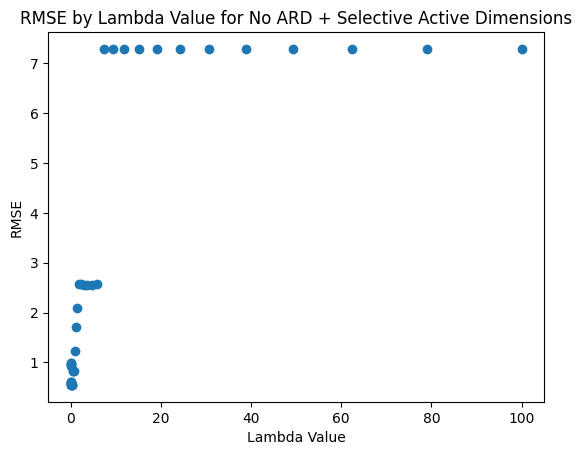

In [737]:
plt.scatter(lbda_vals_3b, rmse_vals_3b)
plt.title('RMSE by Lambda Value for No ARD + Selective Active Dimensions')
plt.ylabel('RMSE')
plt.xlabel('Lambda Value')
plt.show()

In [738]:
rmse3b = np.min(rmse_vals_3b)
lbda3b = lbda_vals_3b[np.argmin(rmse_vals_3b)]

print(f'Lowest RMSE: {rmse3b:.3f}')
print(f'Best Lambda: {lbda3b:.3f}')

Lowest RMSE: 0.548
Best Lambda: 0.134


### 4. Optimizing Directly - separate lengthscales

In [739]:
A_init = tf.zeros((m, 1), dtype=tf.float64)
b_init = tf.zeros((1,), dtype=tf.float64)

kernel = gpf.kernels.SquaredExponential(lengthscales = np.ones(m))
likelihood = gpf.likelihoods.Gaussian()
mean_function = gpf.functions.Linear(A=A_init, b = b_init) 

opt = gpf.optimizers.Scipy()


mod4 = gpf.models.GPR(
    data=(Xtrain, ytrain), 
    kernel=kernel, 
    likelihood = likelihood,
    mean_function = mean_function
    )

In [740]:
def training_loss_lasso(model, lambda_val = 0):
    base_loss = model.training_loss()
    l1_penalty = lambda_val * tf.reduce_sum(tf.abs(model.mean_function.A))
    total_loss = base_loss + l1_penalty
    return total_loss

opt = gpf.optimizers.Scipy()
opt.minimize(
    lambda: training_loss_lasso(mod4, 0.2), 
    mod4.trainable_variables,   
)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 42.25723455886967
        x: [ 5.413e-01  5.413e-01 ...  5.236e-02 -6.670e-01]
      nit: 65
      jac: [ 0.000e+00  0.000e+00 ... -1.372e-03  1.071e-04]
     nfev: 76
     njev: 76
 hess_inv: <203x203 LbfgsInvHessProduct with dtype=float64>

In [741]:
mod4

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,,True,"(100, 1)",float64,[[-3.52494372e-02...
GPR.mean_function.b,Parameter,Identity,,True,"(1,)",float64,[-0.66703811]
GPR.kernel.variance,Parameter,Softplus,,True,(),float64,0.047653380237039515
GPR.kernel.lengthscales,Parameter,Softplus,,True,"(100,)",float64,"[1., 1., 1...."
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,0.04765433836031327


In [742]:
y_pred4, y_var4 = mod4.predict_y(Xtest)
rmse4 = mean_squared_error(ytest, y_pred4, squared=False)
print(f'RMSE Model 4: {rmse4:.3f}')

RMSE Model 4: 0.850


#### 4b. Testing Against Different Lambda Values

In [743]:
A_init = tf.zeros((m, 1), dtype=tf.float64)
b_init = tf.zeros((1,), dtype=tf.float64)

kernel = gpf.kernels.SquaredExponential(lengthscales = np.ones(m))
likelihood = gpf.likelihoods.Gaussian()
mean_function = gpf.functions.Linear(A=A_init, b = b_init) 

opt = gpf.optimizers.Scipy()

In [744]:
rmse_vals_4b = []
lbda_vals_4b = []


for lbda in np.logspace(-2, 2, 40):
    A_init = tf.zeros((m, 1), dtype=tf.float64)
    b_init = tf.zeros((1,), dtype=tf.float64)

    kernel = gpf.kernels.SquaredExponential(lengthscales = np.ones(m))
    likelihood = gpf.likelihoods.Gaussian()
    mean_function = gpf.functions.Linear(A=A_init, b = b_init) 
    mod4b= gpf.models.GPR(
        data=(Xtrain, ytrain), 
        kernel=kernel, 
        likelihood = likelihood,
        mean_function = mean_function
        )
    
    opt.minimize(
    lambda: training_loss_lasso(mod4b, lbda), 
    mod4b.trainable_variables)
    y_pred, y_var = mod4b.predict_y(Xtest)
    rmse = mean_squared_error(ytest, y_pred, squared=False)

    rmse_vals_4b.append(rmse)
    lbda_vals_4b.append(lbda)

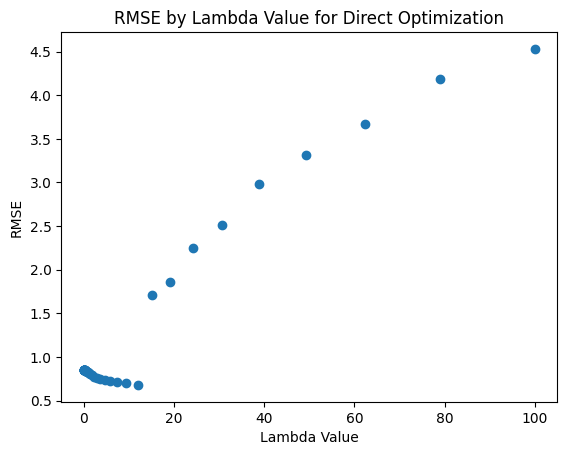

In [745]:
plt.scatter(lbda_vals_4b, rmse_vals_4b)
plt.title('RMSE by Lambda Value for Direct Optimization')
plt.ylabel('RMSE')
plt.xlabel('Lambda Value')
plt.show()

In [746]:
rmse4b = np.min(rmse_vals_4b)
lbda4b = lbda_vals_4b[np.argmin(rmse_vals_4b)]

print(f'Lowest RMSE: {rmse4b:.3f}')
print(f'Best Lambda: {lbda4b:.3f}')

Lowest RMSE: 0.681
Best Lambda: 11.938


## Results of All Models

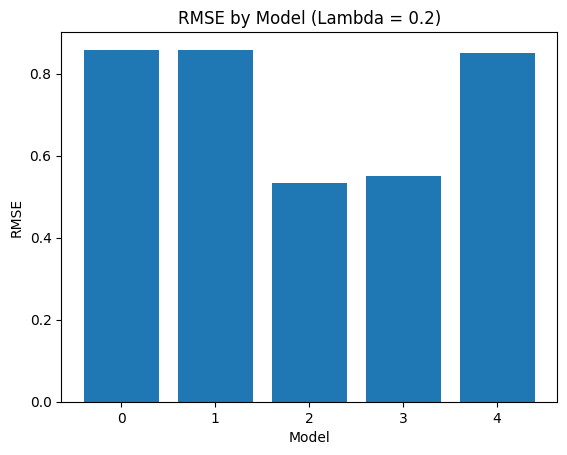

In [747]:
rmse_vals = [rmse0, rmse1, rmse2, rmse3, rmse4]

plt.bar(range(5), rmse_vals)
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.title('RMSE by Model (Lambda = 0.2)')
plt.show()

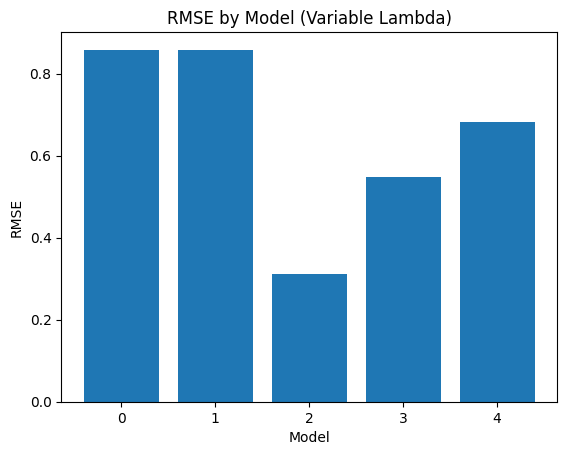

In [748]:
rmse_vals_b = [rmse0, rmse1, rmse2b, rmse3b, rmse4b]

plt.bar(range(5), rmse_vals_b)
plt.ylabel('RMSE')
plt.xlabel('Model')
plt.title('RMSE by Model (Variable Lambda)')
plt.show()